# Convex Optimization - Homework 3

In [11]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from scipy.linalg import inv
import sklearn
from sklearn.datasets import make_regression

## Question 2

Implement the barrier method to solve QP.

In [21]:
# Definition of useful functions

def grad(Q,p,A,b,t,v):
    return (t*(2*Q@v+p) + A.T@(b-A@v)**(-1))
    

def hessian(Q,p,A,b,t,v):
    s = 0
    for i in range (A.shape[0]):
        s = s + (b-A@v)[i]**(-2)*  (A[i,].reshape(-1,1))@(A[i,].reshape(1,-1))
    return (2*t*Q+s)

def f(Q,p,A,b,t,v):
    return t*(v.T@Q@v + p.T.dot(v)) - np.sum(np.log(b-A.dot(v)))

In [26]:
#  Newton method to solve the centering step given the inputs

def centering_step(Q,p,A,b,t,v0,eps):
    
    V = [v0]
    i = 0
    Continue = True
    
    while Continue:
        v = V[-1]
        newt_step = -inv(hessian(Q,p,A,b,t,v)).dot(grad(Q,p,A,b,t,v))
        lambda_sq = -grad(Q,p,A,b,t,v).T.dot(newt_step)
        
        Continue = (lambda_sq/2 >= eps)
        if not Continue:
            break
            
        else:
            i += 1
            
# Line search backtracking 
            T = 1
            while not(((b-A.dot(v+T*newt_step))>0).all()) or (f(Q,p,A,b,t,v+T*newt_step) > f(Q,p,A,b,t,v) + alpha*T*grad(Q,p,A,b,t,v).T.dot(newt_step)):
                T = beta*T
            
            v = v + T*newt_step
            V.append(v)
    return (V[-1], i)

In [27]:
# Barrier method using the centering step to solve the problem

def barr_method(Q,p,A,b,v0,eps,mu):
    t = 1  
    m = A.shape[0]
    V = [v0]
    i_newton = [0]
    Continue = (m/t >= eps)
    while Continue:
        v0, i = centering_step(Q,p,A,b,t,v0,0.00001)
        V.append(v0)
        i_newton.append(i_newton[-1]+i)
        t = mu*t
        Continue = (m/t >= eps)
    
    return (V, i_newton)

## Question 3

Test your function on randomly generated matrices $X$ and observations y with $λ = 10$. Plot precision criterion and gap $f(vt)−f∗$ in semilog scale (using the best value found for $f$ as a surrogate for $f∗$). Repeat for different values of the barrier method parameter $μ = 2, 15, 50, 100, . . .$ and check the impact on w. What would be an appropriate choice for $μ$ ?

In [28]:

n =10
d = 100

np.random.seed()
X,y,coef = make_regression(n_samples=n, n_features=d, n_informative=10, coef=True, noise = 1)
y = y.reshape((-1,1))

alpha = 0.01 
beta = 0.5   
Lambda = 10

Q = 0.5*np.eye(n)
p = -y
A = np.vstack((X.T,-X.T))
b = Lambda*np.ones((2*d,1))
v0 = np.zeros((n,1))
eps = 0.001

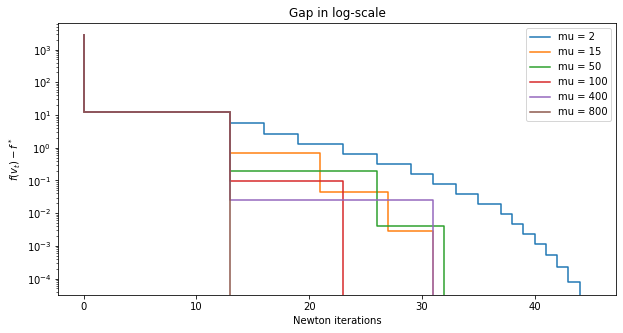

In [29]:
plt.figure(figsize=(10,5)) 

for mu in [2,15,50,100,400,800]:
    V, i_newton = barr_method(Q,p,A,b,v0,0.001,mu)
    v_star = V[-1]
    values = [(v0.T@Q@v0 + p.T.dot(v0))[0,0] - (v_star.T@Q@v_star + p.T.dot(v_star))[0,0] for v0 in V]
    plt.step(i_newton, values, label='mu = '+str(mu))

plt.title ('Gap in log-scale') 
plt.legend()
plt.semilogy()
plt.xlabel('Newton iterations')
plt.ylabel('$f(v_t)-f^*$')

plt.show()

For a low value of mu, the steps are small but the convergence is slow. For a high value of mu, the steps are larger and the convergence is faster. 

An appropriate choice for $\mu$ would be around 50 in order to have a not-to-small convergence. 